# Stock Price Prediction with ProphetForecaster and AutoProphet (with AutoML)

In this notebook, we demonstrate a reference use case where we use historical stock price data to predict the future price using the ProphetForecaster and AutoProphet. The dataset we use is the daily stock price of S&P500 stocks during 2013-2018 ([data source](https://www.kaggle.com/camnugent/sandp500/)). 

Reference: https://facebook.github.io/prophet, https://github.com/jwkanggist/tf-keras-stock-pred

## Download raw dataset and load into dataframe

Now we download the dataset and load it into a pandas dataframe. Steps are as below.

+ First, run the script `get_data.sh` to download the raw data. It will download daily stock price of S&P500 stocks during 2013-2018 into data folder, preprocess and merge them into a single csv file `all_stocks_5yr.csv`.

+ Second, use pandas to load data/data.csv into a dataframe as shown below

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
FILE_NAME = 'all_stocks_5yr.csv'

filepath = os.path.join('data', FILE_NAME)
print(filepath)

data/all_stocks_5yr.csv


In [3]:
# read data
data = pd.read_csv(filepath)
print(data[:10])

         date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL
5  2013-02-15  13.93  14.61  13.93  14.50  15628000  AAL
6  2013-02-19  14.33  14.56  14.08  14.26  11354400  AAL
7  2013-02-20  14.17  14.26  13.15  13.33  14725200  AAL
8  2013-02-21  13.62  13.95  12.90  13.37  11922100  AAL
9  2013-02-22  13.57  13.60  13.21  13.57   6071400  AAL


In [4]:
# change input column name 
data = data[data['Name']=='MMM'].rename(columns={"date":"ds", "close":"y"})
data.head()

,ds,open,high,low,y,volume,Name
381385,2013-02-08,102.34,103.330,102.0400,102.66,1937721,MMM
381386,2013-02-11,102.39,102.880,102.0401,102.62,1715444,MMM
381387,2013-02-12,102.66,103.590,102.6300,103.46,1927930,MMM
381388,2013-02-13,103.03,103.395,102.5800,102.86,1699804,MMM
381389,2013-02-14,102.43,103.140,102.2200,102.78,2217419,MMM


## Data Pre-processing
Now we need to do data cleaning and preprocessing on the raw data. Note that this part could vary for different dataset.

For the stock price data we're using, we add normlization such that the normalized stock prices fall in the range of 0 to 1. And here we aims at using historical values to predict stock prices of future 24 days.

We generate a built-in TSDataset to complete the whole processing.

In [5]:
from zoo.chronos.data import TSDataset
from sklearn.preprocessing import MinMaxScaler

df = data[["ds", "y"]]
df_train = df[:-24]
df_test = df[-24:]

tsdata_train = TSDataset.from_pandas(df_train, dt_col="ds", target_col="y")
tsdata_test = TSDataset.from_pandas(df_test, dt_col="ds", target_col="y")

minmax_scaler = MinMaxScaler()

for tsdata in [tsdata_train, tsdata_test]:
    tsdata.scale(minmax_scaler, fit=(tsdata is tsdata_train))

train_data = tsdata_train.to_pandas()
validation_data = tsdata_test.to_pandas()
print(train_data.shape[0])
print(validation_data.shape[0])

1235
24


## ProphetForecaster Demonstration
Here we provide a simple demonstration of basic operations with the ProphetForecaster.

In [6]:
from zoo.chronos.model.forecast.prophet_forecaster import ProphetForecaster

In [7]:
model = ProphetForecaster()
val_mse = model.fit(data=train_data, validation_data=validation_data)['mse']
print(f"Validation MSE = {val_mse}")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Validation MSE = 0.003976707703093828


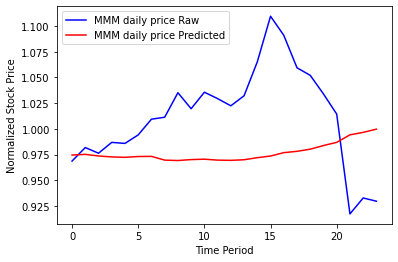

In [8]:
# Plot predictions
pred = model.predict(ds_data=validation_data[["ds"]])

import matplotlib.pyplot as plt
plt.plot(validation_data[['y']].values, color='blue', label="MMM daily price Raw")
plt.plot(pred[['yhat']].values, color='red', label="MMM daily price Predicted")
plt.xlabel("Time Period")
plt.ylabel("Normalized Stock Price")
plt.legend()
plt.show()

## AutoProphet Demonstration
Here we provide a demonstration of our AutoProphet AutoEstimator that could search for best hyperparameters for the model automatically.

In [9]:
from zoo.chronos.autots.model.auto_prophet import AutoProphet
from zoo.automl.recipe.base import Recipe
from zoo.orca.automl import hp
from zoo.orca import init_orca_context

In [10]:
init_orca_context(init_ray_on_spark=True)

Initializing orca context
Current pyspark location is : /home/junweid/spark-2.4.3/spark-2.4.3-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /home/junweid/intel_PR4/analytics-zoo/zoo/target/analytics-zoo-bigdl_0.13.0-spark_2.4.6-0.12.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
Successfully got a SparkContext


2021-08-18 00:31:25,278	INFO services.py:1174 -- View the Ray dashboard at http://10.239.44.67:8265


{'node_ip_address': '10.239.44.67', 'raylet_ip_address': '10.239.44.67', 'redis_address': '10.239.44.67:6379', 'object_store_address': '/tmp/ray/session_2021-08-18_00-31-24_776918_5222/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2021-08-18_00-31-24_776918_5222/sockets/raylet', 'webui_url': '10.239.44.67:8265', 'session_dir': '/tmp/ray/session_2021-08-18_00-31-24_776918_5222', 'metrics_export_port': 39101, 'node_id': 'e16b991ed62fe289bec95fd7a0dfc7f2b0d755cb675bf5a153e95294'}


<SparkContext master=local[2] appName=pyspark-shell>

In [11]:
auto_prophet = AutoProphet()

n_sampling = 20

auto_prophet.fit(data=train_data,
                 n_sampling=n_sampling)

print("Training completed.")

2021-08-18 00:32:00,210	INFO tune.py:450 -- Total run time: 28.75 seconds (28.68 seconds for the tuning loop).
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Training completed.


In [12]:
y_hat = auto_prophet.predict(ds_data=validation_data[["ds"]])

In [13]:
test_mse = auto_prophet.evaluate(data=validation_data, metrics=["mse"])
print(f"Validation MSE = {test_mse}")

Validation MSE = [array(0.00545738)]


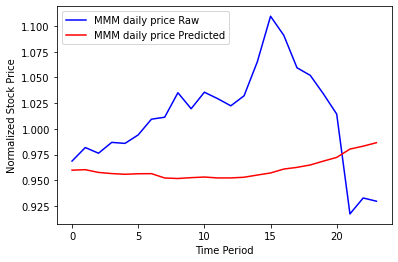

In [14]:
# Plot predictions
import matplotlib.pyplot as plt
plt.plot(validation_data[['y']].values, color='blue', label="MMM daily price Raw")
plt.plot(y_hat[['yhat']].values, color='red', label="MMM daily price Predicted")
plt.xlabel("Time Period")
plt.ylabel("Normalized Stock Price")
plt.legend()
plt.show()